# **Research question and Motivation**

<img src="Screenshots/c9.PNG" width='480'>

# Motivation
*   I really want to use this api which comes from HaveIbeenPwned because I personally had my private information stolen and part of large data breaches. Typically you can put your phone number or email and find if you have been the victim of a data breach or even multiple. One of the main proponents of data breaches are passwords because they are incredibly valuable especially given people resuse passwords.

*   HaveIbeenPwned allows you to search if a password has been breached and if so it provides the number of times it has been breached. So I found it interesting if I combined the idea of passwords and the names of the most famous athletes because I also like sports

# Topic at hand
* My hypothesis, is that athletes that are more famous are more likely to have some variation of their name used as a password. In other words, the more popular the athelte is, the more times that the corresponding passwords will show up under a data breach.(Assuming data breaches are mostly random) To represent fame, I aggregate different features ,such as total earning through endorsements, followers on social media and as well as the sport that they play.


A sha1 encoding of a password is a 20 byte hash value, used for checking authenticity. HIBP(HaveIbeenPwned) api provides a search by range by the first 5 bytes of the hash as the key and it outputs the remaining 15 bytes appended with a : and the number of data breaches corresponding to many passwords with the same key. After finding the transforming each name eg.cristanoronalod to cristianoronalado25, I can compute the hash and then call a get(url prepended with the first 5 characters of the sha1). The later 15 characters on the list indicates a hit.
![SegmentLocal](Screenshots/c3.gif "segment")

**Data Gathering**
===============
* I collected data from [Espn's world fame 100(2019)](https://www.espn.com/espn/feature/story/_/id/26113613/espn-world-fame-100-2019) which presents the 100 most famous athletes during 2019. I opted to use the selenium webdriver module because some of the html is java script loaded, so if I used get from the requests module, it would not show any of the information that I want. Afterwards, I did utlized beautiful soup to parse the html for thumbnails of the players.From the thumbnails, I was able to find, their name,(rating calculated by ESPN), total endorsements, follower count,sport and country.

<img src="Screenshots/c1.PNG" width='480'>

* Since the Espn website only provides 100 athletes, I figured it would be beneificial to find another website or data set to scrape. This was pretty difficult and lacked forsight as I was pigeonholed into athlete endorsement and followers statistics from 2019. Eventualli I found [opendorse's top 100 highest paid athletes](https://opendorse.com/blog/top-100-highest-paid-athlete-endorsers-2019/) This website included some new features such as a description,estimated value per social media post,and notable endorsement deals,so I decided to only take the features that overlapped with the additional athletes that were not previously listed. Furthermore I opted to drop the country and rating/search score columns from my dataFrame since that feature is unique to the Espn website.

**Data Cleaning**
===============

<img src="Screenshots/c5.PNG" width='480'>


# Endorsements and Followers

* In the Espn article, I needed to convert all columns to numeric. For the endorsements, I found that I could delete the \$ sign by taking a slice that omits the first character. For converting the suffix such as m to millions or k for thousands, I used a regular expression to extract the suffix and put it as its own column in the dataframe. Afterwards, I removed the suffix from the endorsements column and then replaced the now numeric value in endorsements corresponding to the value of the suffix multiplied by its current value.Lastly, I dropped the suffix columns because they were not neccesary. The followers was very similar to the endorsements, other than the fact that It does not need the removal of the $ sign.
-----------------
`df['suffix1']=df['endorsements'].str.extract(r'([mk])+')`  \Extract suffix

`df['endorsements']=(df['endorsements'].str[1:].replace(r'[mk]+$','',regex=True))` \remove suffix



-------------------------------------------------------------------------------------------------------

`df['endorsements']=pandas.to_numeric(df['endorsements'],errors='coerce')`

`df.loc[df['suffix1']=='m','endorsements']=df['endorsements']*10**6`                \Calculate actual value

`df.loc[df['suffix1']=='k','endorsements']=df['endorsements']*10**3`                 \Calculate actual value

# Categorical data cleaning (name,sport,country)
* For the general case, I found that categorical data was appended with a bunch of white space characters, especially tabs, so I used the lambda strip to strip all white space characters.
`df[df.columns]=df.apply(lambda x: x.str.strip())` \\strip white space characters
* For the sport, I used a replace to delete the unicode bullet that was prepended to every sport, but I also suppose I could have just taken a slice of the string.
* One instance of American Football was mispelled with a lower case f
* One name contained the latin u, which was omitted, so I had to reinsert it
---------------------

`df['sport']=df['sport'].str.replace('•','')`       \\remove bullet point

`df.loc[df['sport'=='American football'],'sport']='American Football'` \\fix typo

`df.loc[df['name']=='thomas-mller','name']='thomas-muller'` \\insert u


**Data Cleaning(Cont...)**
===============

<img src="Screenshots/c6.PNG" width='480'>

# Endorsements and Followers

* For the endorsements, I split the string with : as the delimeter and took the 1st element, then I took a slice that excluded the dollar sign and removed all comma marks. For the twitter followers, I also split the string with the : delimeter and took the 1st element and then did the same technique I used on the ESPN website by extracting the suffix and multipliying it's equivalent value by the numeric value of the root. The one difference is that this website uses, the capital M and capital K for the suffixes, so I had to change my regular expression.
----------
`endorsements2=(en.text).split('$')[1].replace(',','').strip()` \remove \$ sign and commas


# Categorical features(name, sport)

* To get the name, I also use split, but with the | as the delimeter and the first occurance of a period as the delimeter. I also made the decision to remove all dashes,commas and periodsd in names, such as in Otto Porter, Jr. to simplify their names.

* In the sport, they did not explcitly put the sport, such as in the Espn article, so I did found all the unique leagues, such as ATP and PGA tour and replaced them with their respective sport. I got the sport from getting the element after the | delimeter in the name.
-------------------------
`name2=player_thumbnail2.text.split('|')[0].split('.',1)[1].strip().replace(' ','-').replace('.','-').replace(',','-').lower()` \name

-------------------------------
`df2['sport'].replace('La Liga','Soccer',inplace = True)`   \These are only two of several

`df2['sport'].replace('ATP Tour','Tennis',inplace = True)`


In [1]:
import warnings
import matplotlib
import pandas as pd
from athletes_df import *

warnings.filterwarnings('ignore')

df=create_df()
df['total_breaches']=0
df['unique_breaches_by_name']=0
df['name'].replace('-','',regex=True,inplace = True)

f= open('breaches.txt','r')
for line in f.readlines():
    breached_data = line.split(':')
    df.set_index('name')
    df.loc[df['name']==(breached_data[0].strip()),'total_breaches']+=int(breached_data[2].strip())
    df.loc[df['name']==(breached_data[0].strip()),'unique_breaches_by_name']+=1
f.close()

f= open('breaches2.txt','r')
for line in f.readlines():
    breached_data = line.split(':')
    df.set_index('name')
    df.loc[df['name']==(breached_data[0].strip()),'total_breaches']+=int(breached_data[2].strip())
    df.loc[df['name']==(breached_data[0].strip()),'unique_breaches_by_name']+=1
f.close()

df.drop(columns={'rating','country'},inplace = True) #Data Cleaning are all NAN vallues for 101-157
print(df.head(150))

     index              name  endorsements    followers       sport  \
0        0  cristianoronaldo    37000000.0  148000000.0      Soccer   
1        1       lebronjames    52000000.0   45300000.0  Basketball   
2        2       lionelmessi    28000000.0  103100000.0      Soccer   
3        3            neymar    19000000.0  107200000.0      Soccer   
4        4     conormcgregor    15000000.0   29700000.0         MMA   
..     ...               ...           ...          ...         ...   
145     88       jrueholiday      500000.0     142000.0  Basketball   
146     89      ottoporterjr      500000.0      87000.0  Basketball   
147     90    yoeniscespedes      400000.0     149000.0    Baseball   
148     91   sebastianvettel      300000.0          0.0      Racing   
149     92    felixhernandez      300000.0     292000.0    Baseball   

     total_breaches  unique_breaches_by_name  
0              5631                       56  
1             12385                      163  
2     

**Data Visualization**
=====================

## total_breaches by name


count       157.000000
mean       3048.579618
std       21070.507745
min           0.000000
25%           5.000000
50%          45.000000
75%         424.000000
max      228149.000000
Name: total_breaches, dtype: float64


<AxesSubplot:title={'center':'Distribution of total_breaches'}, xlabel='name'>

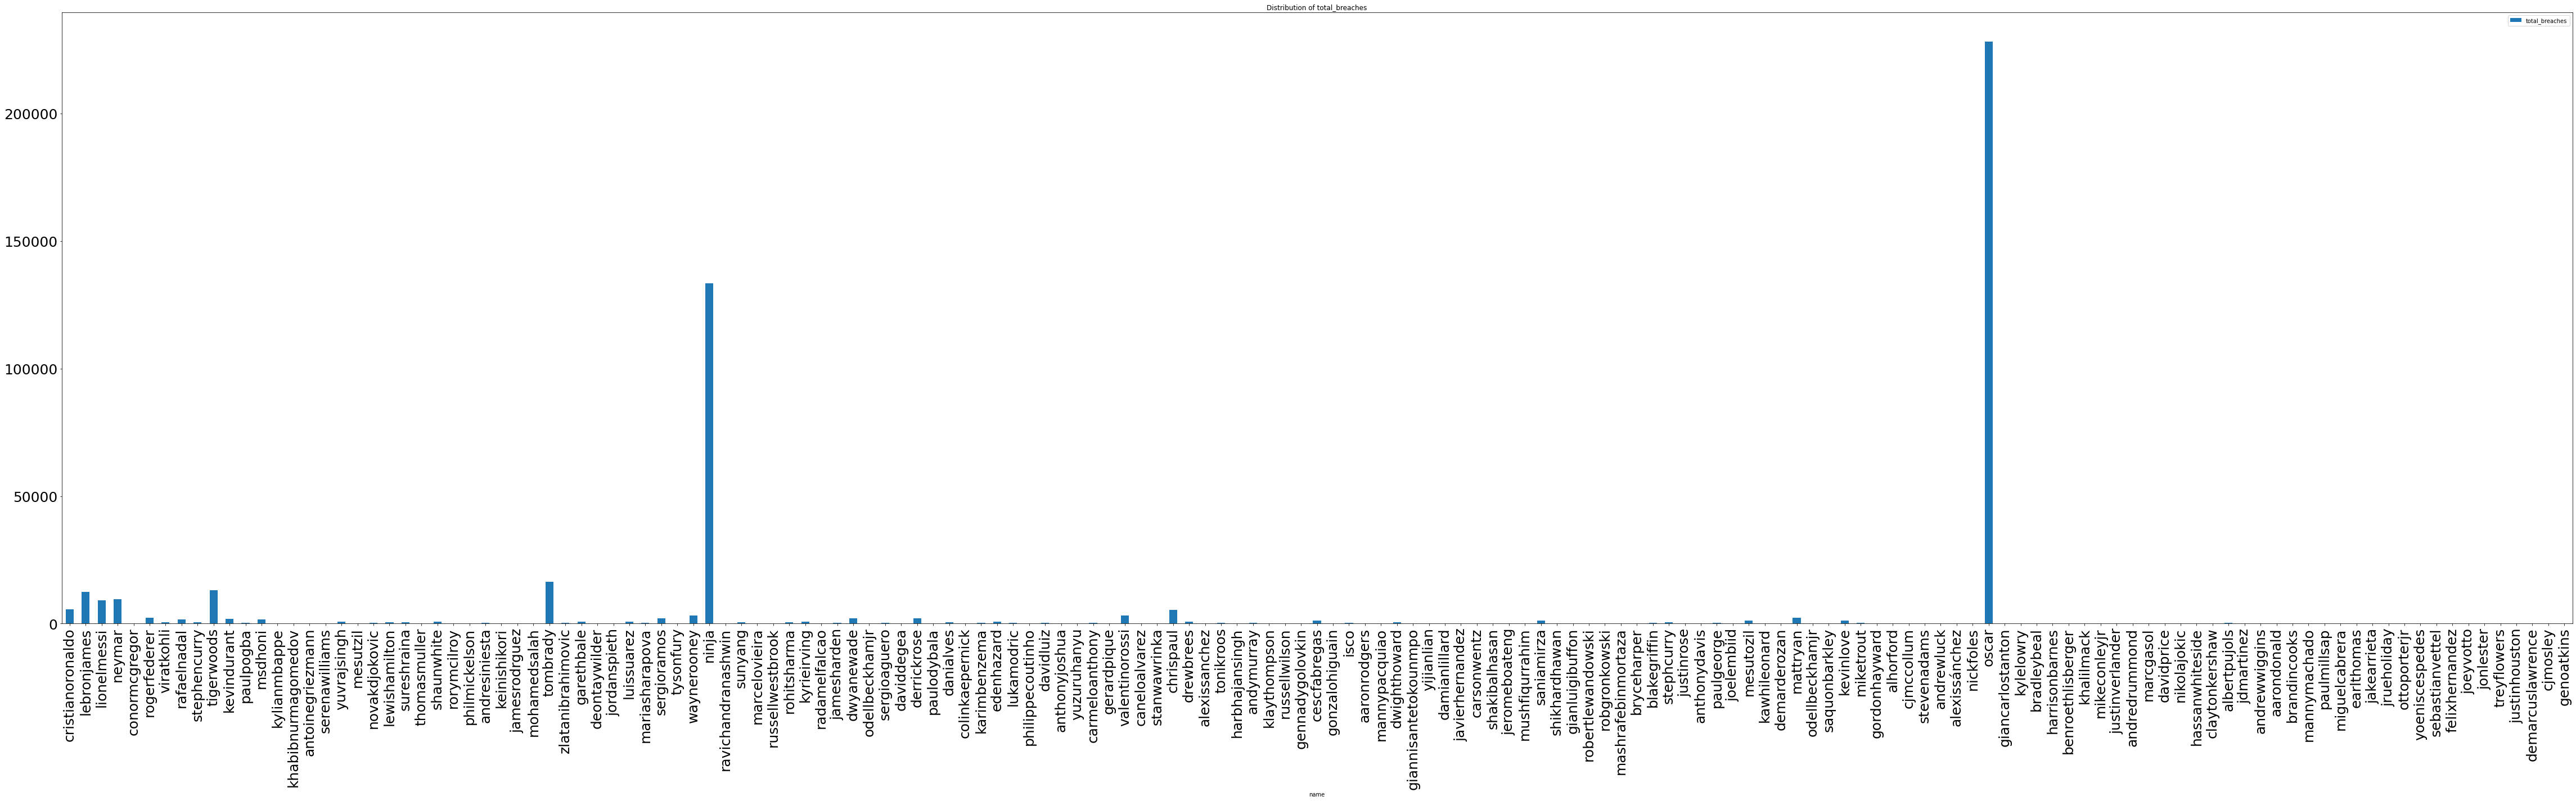

In [2]:
print(df['total_breaches'].describe())
df.plot(kind='bar',x='name',y='total_breaches',fontsize='25',figsize=(80,20),title='Distribution of total_breaches',legend = True)

* Let's drop ninja because he is a very common dictionary wordfirst name with no last name, making then both extreme outliers. Hopefully after this, or graph will depict some sort of trend and will have a significantly lower standard deviation

In [3]:
df=df.drop(df.index[df['name']=='ninja'])
df=df.drop(df.index[df['name']=='oscar'])

## total_breaches by name'

count      155.000000
mean       755.941935
std       2288.562568
min          0.000000
25%          5.000000
50%         45.000000
75%        412.500000
max      16390.000000
Name: total_breaches, dtype: float64


<AxesSubplot:title={'center':'New Distribution of total_breaches'}, xlabel='name'>

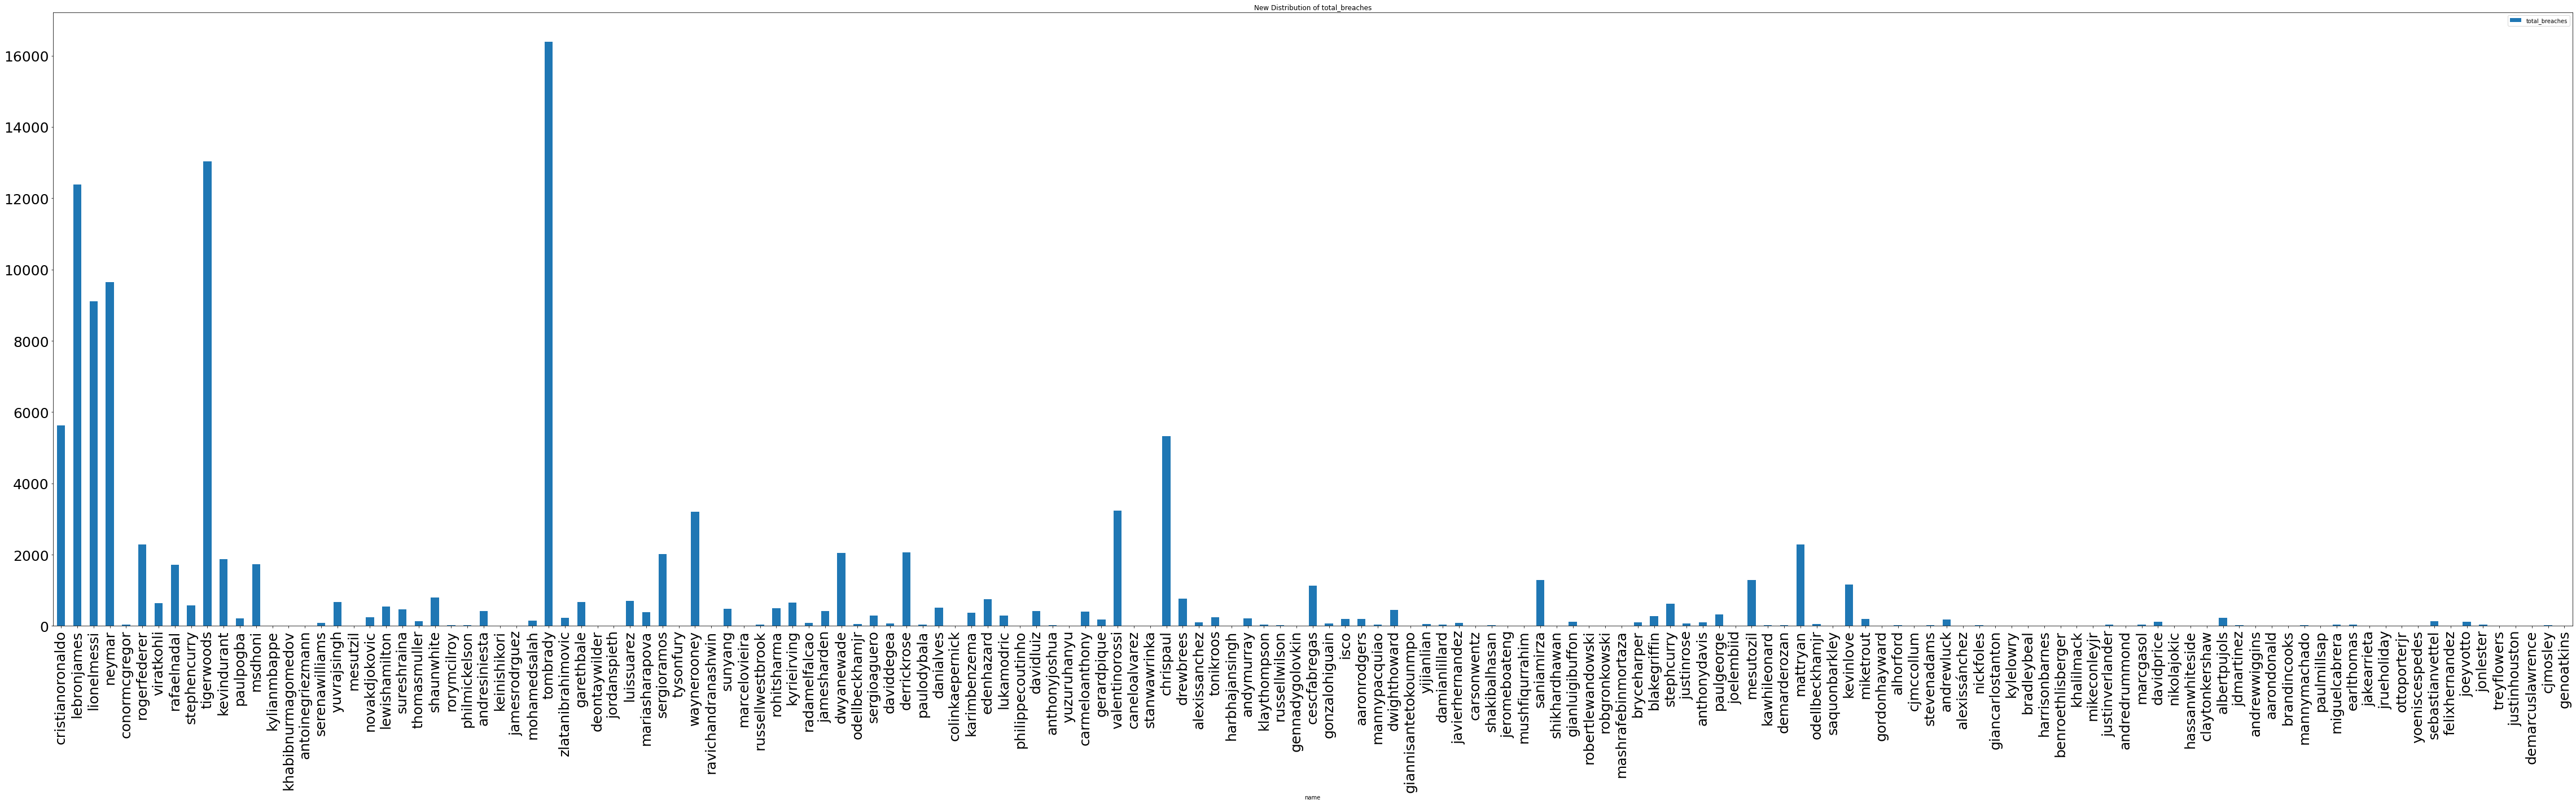

In [4]:
print(df['total_breaches'].describe())
df.plot(kind='bar',x='name',y='total_breaches',fontsize='25',figsize=(80,20),title='New Distribution of total_breaches',legend = True)

**As you can see, this graph looks like a better scale and it depicts a positive skewedness. If we look at the describe, the median is only 1/18 of the mean and the standard deviation is much larger than the mean which indicates high variability. It is also notable that tombrady has an exceptionally high data_breaches amongst its peers and it is the global maximum, despite being closer to the middle of the chart. Since my dataset exhibits high variablity I've opted to not removing tom brady although it is almost 7 standard deviations above the mean.**

## Follower Count vs. Total_breaches

count    1.550000e+02
mean     1.148475e+07
std      1.868983e+07
min      0.000000e+00
25%      6.510000e+05
50%      5.400000e+06
75%      1.495000e+07
max      1.480000e+08
Name: followers, dtype: float64


<AxesSubplot:title={'center':'Follower Count vs Total_breaches'}, xlabel='followers'>

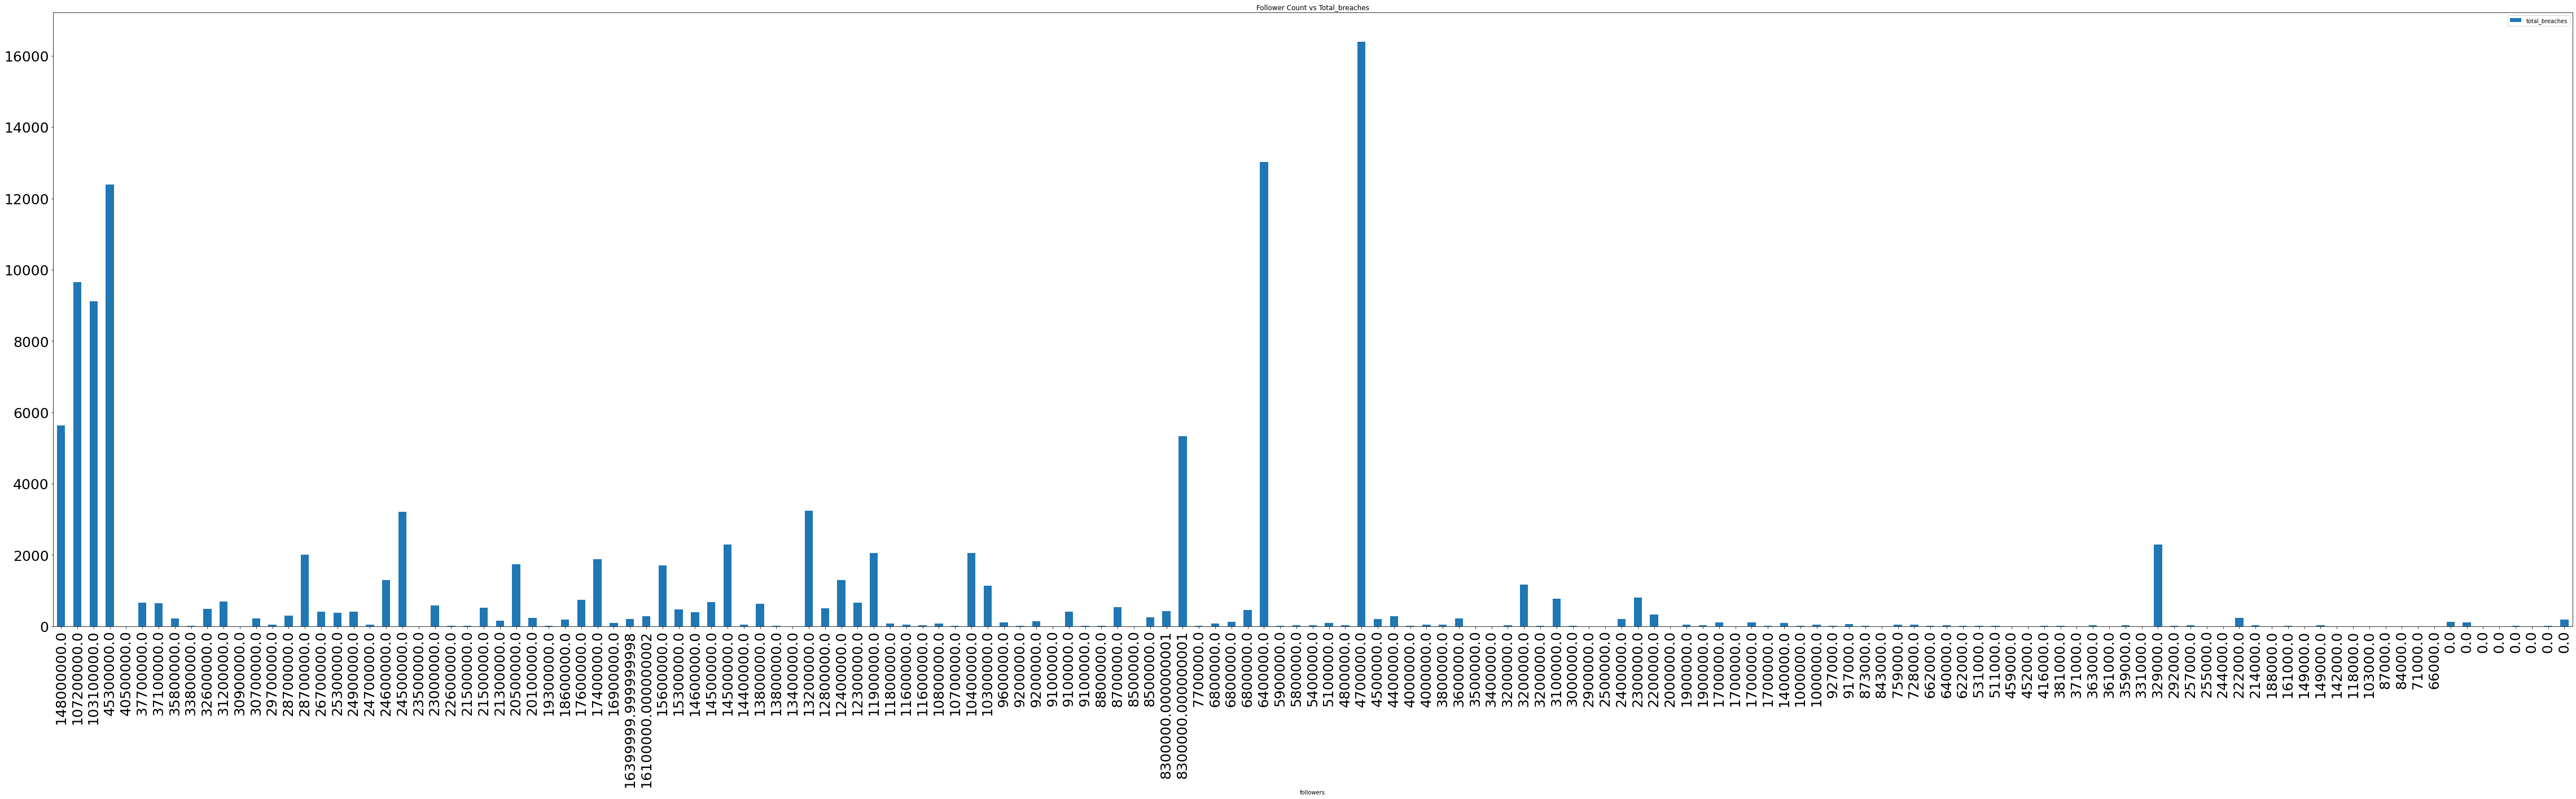

In [5]:
print(df['followers'].describe())
df2=df.sort_values(by='followers',ascending=False)
df2.plot(kind='bar',x='followers',y='total_breaches',fontsize='25',figsize=(80,20),title='Follower Count vs Total_breaches',legend = True)
#print(df2[df2['followers'].isna()])

**This model is not as clear.**

## Endorsements vs. Total_breaches

count    1.550000e+02
mean     9.856613e+06
std      1.109161e+07
min      7.500000e+04
25%      2.065000e+06
50%      5.500000e+06
75%      1.320500e+07
max      5.200000e+07
Name: endorsements, dtype: float64


<AxesSubplot:title={'center':'Endorsements vs Total_breaches'}, xlabel='endorsements'>

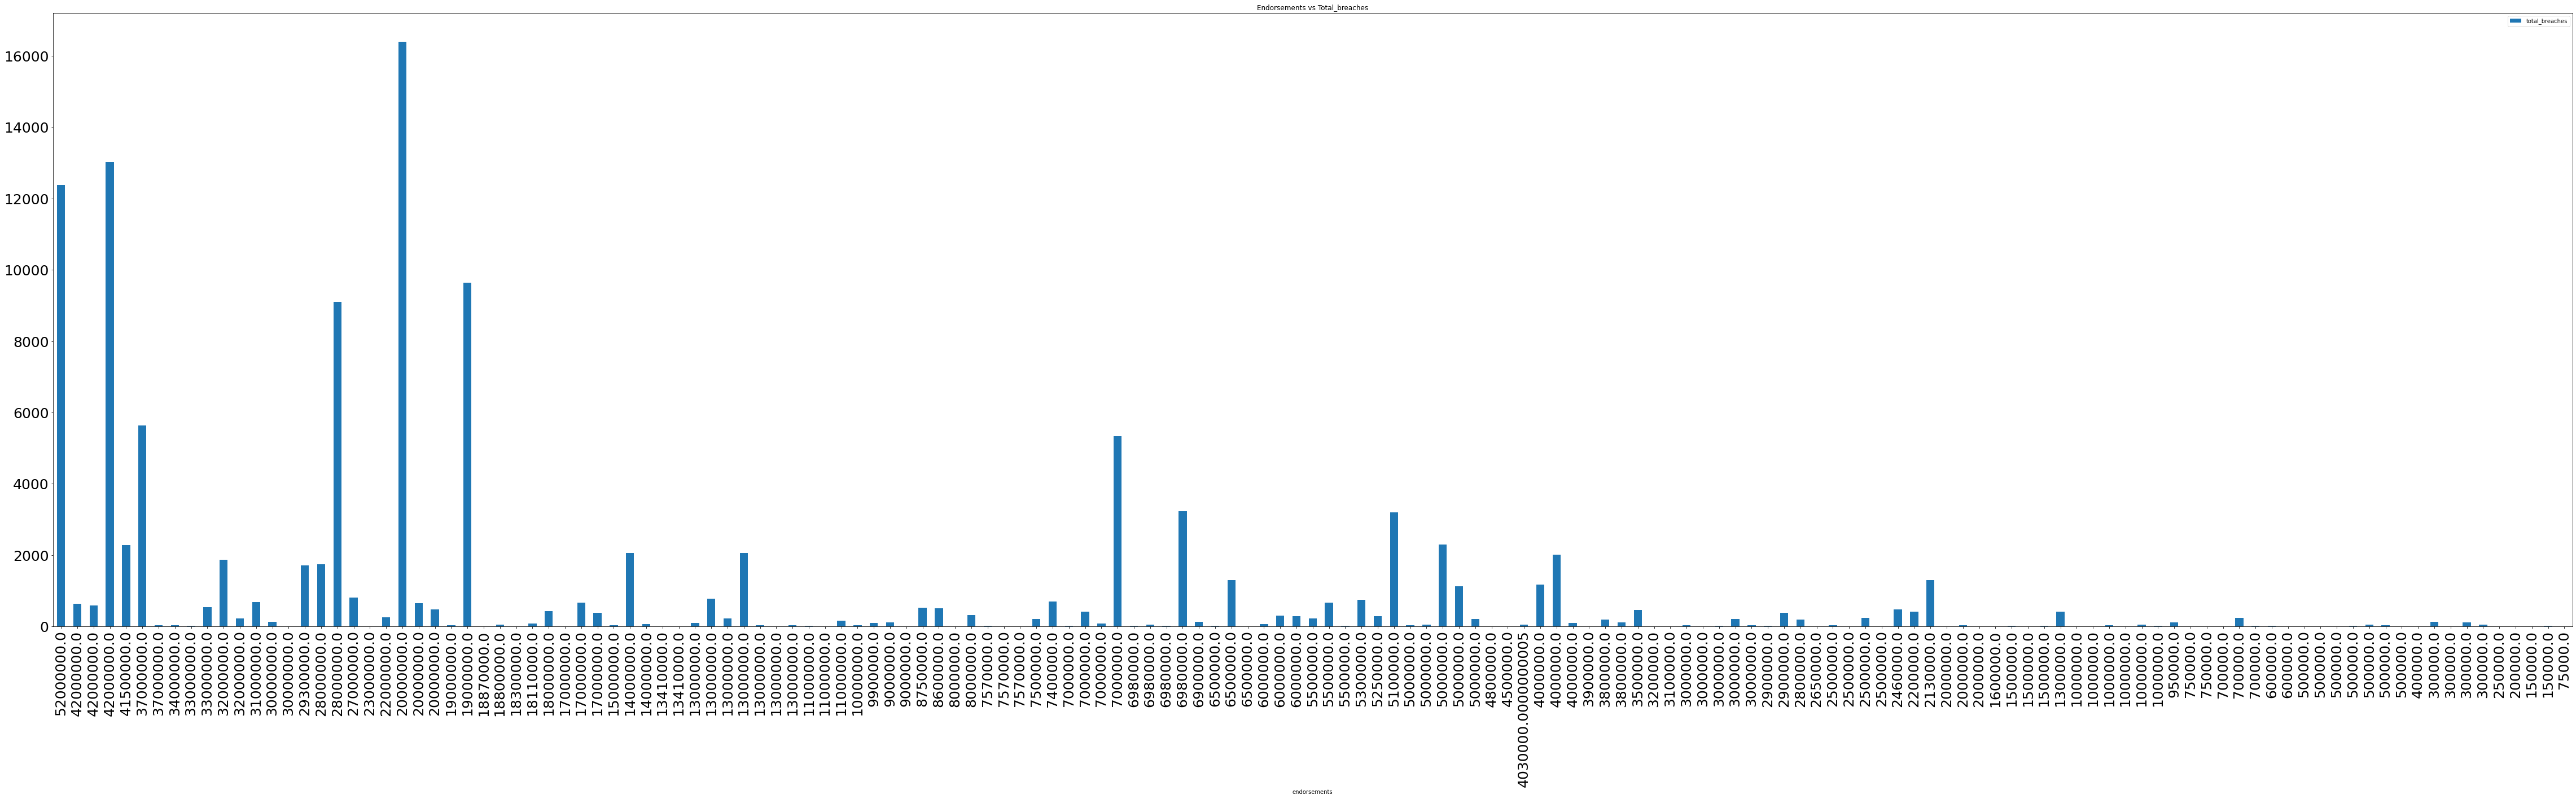

In [6]:
print(df['endorsements'].describe())
df3=df.sort_values(by='endorsements',ascending=False)
df3.plot(kind='bar',x='endorsements',y='total_breaches',fontsize='25',figsize=(80,20),title='Endorsements vs Total_breaches',legend = True)

count        155
unique        15
top       Soccer
freq          39
Name: sport, dtype: object


<AxesSubplot:xlabel='sport'>

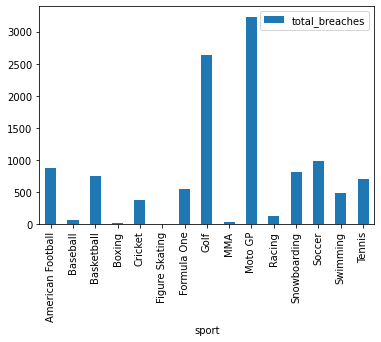

In [7]:
print(df['sport'].describe())
df4=df.groupby('sport').mean()
df4.plot.bar(y='total_breaches')

**I do not think the sport is a usable feature because data is not large enough, so small sports with really popular athletes will appear as extreme outliers. For instance, there is only one instance of Moto GP and he happens to have quite a bit of data_breaches associated with his name**

**Machine Learning**
===============

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
import numpy as np

## Split the dataset (90%-10%)

# Let's start with one feature

In [9]:
train, test = train_test_split(df, test_size=0.1)

X_train=train[['endorsements']]
Y_train=train['total_breaches']

X_test=test[['endorsements']]

# Linear Regression

In [10]:
pipeline = make_pipeline(
          StandardScaler(),
          LinearRegression()
)

pipeline.fit(X=X_train, y=Y_train)

#10 folds
scores = cross_val_score(pipeline,X=X_train,y=Y_train,cv=10)
print(f'mean cross_val_score: {np.mean(scores)}')

mean cross_val_score: -0.8598243084580686


**Display MEAN RMSE**

In [11]:
results=test.copy(deep=True)
results['predicted']=pipeline.predict(X_test)
rms = mean_squared_error(results['total_breaches'], results['predicted'], squared=False)

print(results[['endorsements','total_breaches','predicted']])
print(f'MEAN RMSE: {rms}')

     endorsements  total_breaches    predicted
144      500000.0               0   -73.435880
142      500000.0              38   -73.435880
44     19000000.0              37  1666.856221
118     2500000.0               0   114.703807
68     18300000.0               0  1601.007330
0      37000000.0            5631  3360.113399
74     13000000.0             215  1102.437161
87      9900000.0              89   810.820647
80      5000000.0             204   349.878415
55      8750000.0             515   702.640327
19     22000000.0             252  1949.065750
8      42000000.0             581  3830.462616
79      6000000.0              69   443.948258
65      3800000.0             188   236.994603
82      2500000.0              32   114.703807
61      1300000.0             414     1.819995
MEAN RMSE: 1263.2143284095346


# K Nearest Neighbors

In [12]:
pipeline = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=int(np.sqrt(train.shape[0])))
)

pipeline.fit(X=X_train, y=Y_train)

scores = cross_val_score(pipeline,X=X_train,y=Y_train,cv=10)
print(f'mean cross_val_score: {np.mean(scores)}')

mean cross_val_score: -0.6323544960013084


# Both Features

In [13]:
train, test = train_test_split(df, test_size=0.1)

X_train=train[['endorsements','followers']]
Y_train=train['total_breaches']

X_test=test[['endorsements','followers']]

* This is better with two features, but still not great

In [14]:
pipeline1 = make_pipeline(
          StandardScaler(),
          LinearRegression()
)
pipeline1.fit(X=X_train, y=Y_train)
pipeline2 = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=int(np.sqrt(train.shape[0])))
)
pipeline.fit2(X=X_train, y=Y_train)


ensemble_model_tips = VotingRegressor([
    ("linear", pipeline1.predict()), 
    ("knn", pipeline2.predict())
])

AttributeError: 'Pipeline' object has no attribute 'fit2'